# Example 0: Ground truth

In this example, we will test inference on simulated data. 

## Simulate a grid map with known parameters

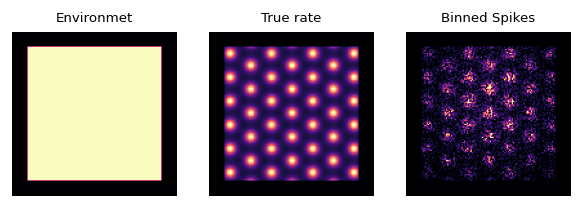

In [1]:
from pylab import *
import sys
sys.path.append('../')
from lgcpspatial.simulate import simulate_data
from lgcpspatial.plot     import *

L   = 128       # Grid size
P0  = L/8       # Grid spacing
α   = 0.5       # Grid "sharpness"
μ   = 10**5/L**2# Mean firing rate (spikes per sample)
pad = 0.1       # Edge padding (Avoids circular convolution wrap-around)

'''
simulate_data(L=128,P=13,α=0.5,μ=0.09)
Simulates spiking observations from a grid cell

Parameters
----------
L: Rectangular binning grid size (L×L bins)
P: Grid cell period spacing
α: Grid cell "sharpness"
μ: Mean firing rate (spikes per sample)

Returns
-------
mask : L×L binary mask of "in bounds" regions 
λ0   : L×L array; "True" sampled grid firing rate
λ0_bg: L×L array; Grid firing rate corrupted by background rate variations
N    : L×L array; Number of visits to each spatial bin
K    : L×L array; Number of spikes recorded in each spatial bin
'''
mask,λ0,λ0_bg,N,K = simulate_data(L,P0,α,μ)

figure(dpi=120)
subplot(131); showim(mask,'Environmet'   )
subplot(132); showim(λ0  ,'True rate'    )
subplot(133); showim(K   ,'Binned Spikes')

datasetname = ('simulated_data_L%d_P%d_α%.2f_μ%0.2f'%(L,P0,α,μ)).replace('.','p')

## Heuristic parameters 

***Always inspect the heuristic initialization.*** If something goes wrong here, grid search will likely also fail. 

Period (bins) estimated from trough: 14.758091618797616
Period (bins) estimated from peak:   15.225262725584749
Period (bins) average:               14.991677172191181
True      period:  16.0
Heuristic period:  14.991677172191181
True log-variance: 0.3835029
Scale (variance):  0.09588305
Scale (Bessel):    0.5063957437730227


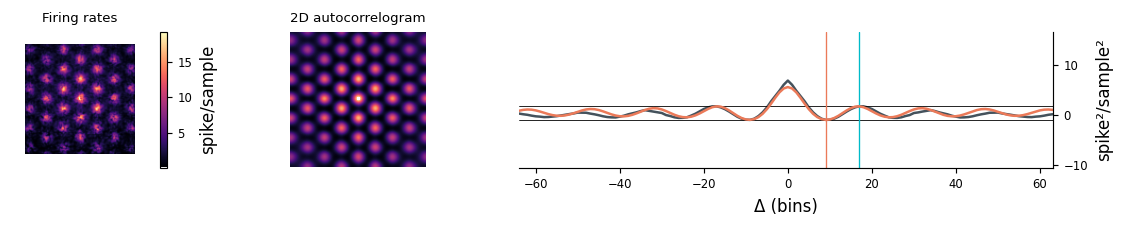

In [2]:
from lgcpspatial.util       import blur, fft_acorr, radial_average, find_peaks, slog
from scipy.special          import j0, jn_zeros
from lgcpspatial.estimators import kde

def guess_period_from_autocorrelation(y,exclude_radius=2,window=True):
    # Estimate the period from the peaks/troughs of autocorrelatogram
    # assuming ideal grid kernel (Bessel function J0)
    # Exclude points close to zero lag, which may be noisy
    autocorrelation = fft_acorr(y,mask,window=window)
    radial_autocorr = radial_average(autocorrelation)
    radial_autocorr = radial_autocorr[L//2+exclude_radius:]
    peaks    = find_peaks( radial_autocorr)[0]+exclude_radius
    troughs  = find_peaks(-radial_autocorr)[0]+exclude_radius
    peak     = np.min(peaks  )
    trough   = argmin(radial_autocorr)+exclude_radius
    P_trough = trough*2*pi/jn_zeros(1,1)[-1]
    P_peak   = peak  *2*pi/jn_zeros(1,2)[-1]
    P_hat    = (P_peak+P_trough)/2
    lo       = np.min(radial_autocorr)
    hi       = radial_autocorr[peak-exclude_radius]
    return P_trough,P_peak,P_hat,lo,hi,trough,peak

# Calculate mean rate per bin without triggering div 0 warnings    
zeros    = N<=0.0
N[zeros] = 1
y        = float32(K/N)
y[zeros] = 0

# Mask to use with imshow
nanmask = float32(mask)
nanmask[~mask] = NaN

# Smooth slightly to prevent noisy peaks
σ = 1
ysmooth1 = blur(K,σ)/blur(N,σ)
P_trough,P_peak,P_hat,lo1,hi1,trough1,peak1 = guess_period_from_autocorrelation(ysmooth1,window=False)
autocorrelation2 = fft_acorr(ysmooth1,mask,window=False)
radial_autocorr2 = radial_average(autocorrelation2)

figure(figsize=(10,2),dpi=120)
grid = (1,4)

# Plot smoothed y
subplot2grid(grid,(0,0))
imshow(ysmooth1*nanmask)
axis('off')
title('Firing rates')
colorbar(label='spike/sample')
# Plot the autocorrelation (mask out zero lag)
subplot2grid(grid,(0,1))
u = array(autocorrelation2)
u[L//2,L//2] = NaN
imshow(u)
axis('off')
title('2D autocorrelogram')
# Plot the radial autocorrelation
subplot2grid(grid,(0,2),colspan=2)
plot(arange(L)-L/2,radial_autocorr2)
rightaxis()
xlabel('Δ (bins)')
ylabel('spike²/sample²')
ylim(10*lo1,10*hi1)
axhline(lo1,lw=0.5,color='k')
axhline(hi1,lw=0.5,color='k')
axvline(trough1,lw=0.8,color=RUST)
axvline(peak1  ,lw=0.8,color=TEAL)

μy = mean(y[mask])
μz = log(μy)

# Get location of trough and peak of ideal (bessel) autocorrelogram
# Get height of function at these locations (height at zero is 1)
# Use covariance of log-Gaussian to predict peak heights
# Get the ratio of these peak heights to use in calibration
# Iterate to guess the scale
observed = hi1-lo1
s = 1
for iters in range(10):
    μz = log(μy)-s/2
    v1,v2 = (exp(j0(jn_zeros(1,2))*s) - 1) * exp(2*μz + s)
    s = s * observed/(v2-v1)
# Plot calibrated "ideal grid" kernel (exponentiated)
# This uses the moments of the multivariate log-Gaussian
x    = arange(L)-L/2
Σ    = j0(x*2*pi/P_hat)*s
expΣ = (exp(Σ)-1)* μy**2
plot(x,expΣ-np.min(expΣ) + lo1)
tight_layout()

# Precompute variables; Passed as globals to jac/hess
fgσ  = P_hat/pi       # In units of linear-bins
bgσ  = fgσ*5          # In units of linear-bins
λh   = kde(N,K,fgσ,mask,rho=1e-9,gamma=0)  # KDE estimated rate
λbg  = kde(N,K,bgσ,mask,rho=1e-9,gamma=0)  # Background rate
lλh  = slog(λh)       # Log rate
μz   = slog(λbg)      # Log background
z0   = lλh - μz       # Foreground log rate

# Initial guess for kernel height
# Standard kernel normalized to zero-lag autocorrelation = 1
# s and σ0 should be similar, they both scale the Bessel autocorrelation of the log-rate
σ1   = var(z0[mask])
σ0   = s

print('Period (bins) estimated from trough:',P_trough)
print('Period (bins) estimated from peak:  ',P_peak)
print('Period (bins) average:              ',P_hat)
print('True      period:  %s'%P0)
print('Heuristic period:  %s'%P_hat)
print('True log-variance: %s'%var(slog(λ0)[mask]))
print('Scale (variance):  %s'%σ1)
print('Scale (Bessel):    %s'%σ0)

## Infer rate map using heuristic parameters

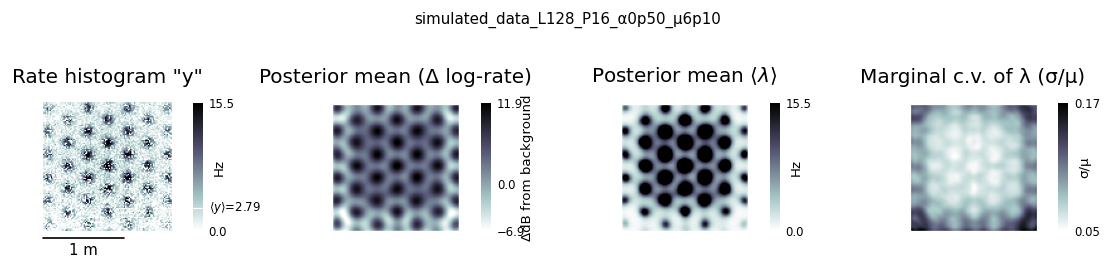

In [3]:
from lgcpspatial.loaddata import Dataset, Arena
from lgcpspatial.lgcp2d   import DiagonalFourierLowrank, coordinate_descent

P     = P_hat
data  = Dataset.create_posthoc(L,N,y,lograte_guess=μz)
data.arena = Arena.from_mask(mask)
data.position_sample_rate = 1 # Hz, but this is fictional for simulated data
data.scale = .5 # 1/Meters, but again: fictional
model = DiagonalFourierLowrank(σ0,P,data)
fit   = coordinate_descent(model,tol=1e-6) # (μh,v,vfe)
inference_summary_plot(model,fit,data,datasetname);

## Identify optimal parameters via grid search

See `example 3 optimize hyperparameters.ipynb` for more details. 

In [4]:
from lgcpspatial.gridsearch import grid_search

modelargs = {
    'L':L,'n':N,'y':y,
    'lograte_guess':z0,
    'prior_mean':μz,
}

def evaluate_ELBO(parameters,state):
    global modelargs
    p,β     = parameters
    model   = DiagonalFourierLowrank(σ0/β,p,**modelargs)
    μ,v,μh  = (None,)*3 if state is None else state
    μ0      = None if μ is None else model.F@μ
    Σ0      = None if v is None else v*0.5
    μh,v,nl = coordinate_descent(model,μ0,Σ0)
    μ       = model.F.T@μh 
    state   = μ,v,μh
    ELBO    = -nl
    return state, ELBO, model

# Prepare hyperparameter grid
rP = 2   # Range (ratio) to search for optimal period
rβ = 10  # Range (ratio) to search for optimal kernel height
NP = 101 # Period search grid resolution
Nβ = 101 # Kernel height search grid resolutions
Ps = float32(exp(linspace(log(P/rP),log(P*rP),NP)))
βs = float32(exp(linspace(log(1/rβ),log(1*rβ),Nβ))[::-1])
pargrid = [Ps,βs]

# Run overall grid search
bestindex,bestpars,bestresult,allresults = grid_search(pargrid,evaluate_ELBO)

print('')
print('Heuristic parameters')
print('P  = %f'%P)
print('σ² = %f'%σ0)
print('')
print('Optimized parameters:')
print('P  = %f'%bestpars[0])
print('σ² = %f'%(σ0/bestpars[1]))
print('')
print('True parameters:')
print('P  = %f'%P0)
print('σ² = %f'%var(slog(λ0)[mask]))

[50,12](1.50e+01,5.75e+00) loss=2.294728e+04(done)

Heuristic parameters
P  = 14.991677
σ² = 0.506396

Optimized parameters:
P  = 14.785282
σ² = 0.088001

True parameters:
P  = 16.000000
σ² = 0.383503


## Infer rate map at optimized parameters

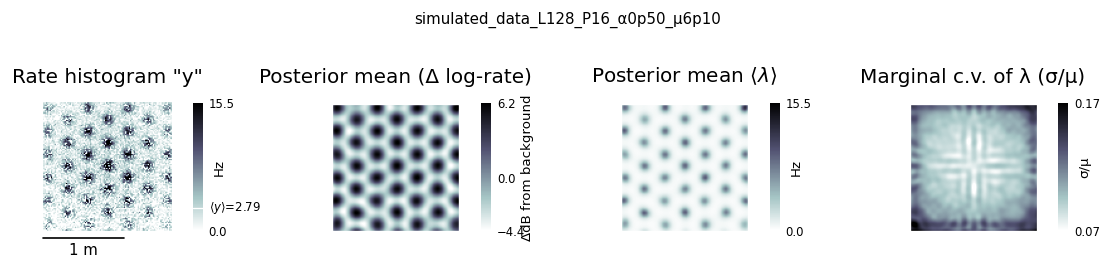

In [5]:
P_use  = bestpars[0]
σ0_use = σ0/bestpars[1]
model  = DiagonalFourierLowrank(σ0_use,P_use,dc=1e6,**modelargs)
fit    = coordinate_descent(model,tol=1e-6)
inference_summary_plot(model,fit,data,datasetname);

## Check accuracy of inferred rates relative to ground truth

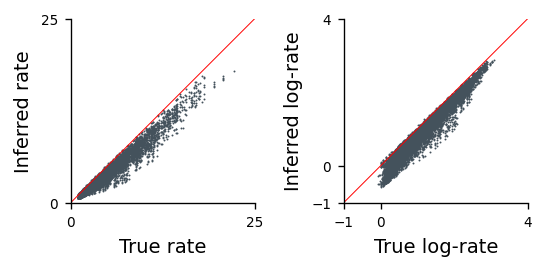

In [6]:
μh,v = fit[:2]
pz = (model.F.T@μh).reshape(L,L)+μz
μλ = exp(pz+v.reshape(L,L)/2)
mλ = exp(pz)
λ  = λ0_bg

def square_limits(limit):
    xlim(*limit)
    ylim(*limit)
    plot(limit,limit,color='r',lw=0.5)
    force_aspect()
    nicexy()
    xlim(*limit)
    ylim(*limit)

figure(0,(4,2),140)
    
subplot(121)
scatter(λ[mask], μλ[mask], lw=0, s=1)
simpleaxis()
xlabel('True rate')
ylabel('Inferred rate')
square_limits([0,25])

z = slog(λ)

subplot(122)
scatter(z[mask], pz[mask], lw=0, s=1)
simpleaxis()
xlabel('True log-rate')
ylabel('Inferred log-rate')
square_limits([-1,4])

tight_layout()